# Estimação do Redshift Fotométrico


Vamos usar metodos de Machine Learning e Deep Learning para estimar o redshift fotométrico.

Para isso vamos utilizar os dados da tabela, match com vvds X DES 

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Baixando Funções que serão usadas nesse notebook")
    ! shred -u astroFunctions.py
    ! wget https://raw.githubusercontent.com/zxcorr/zxcorr_DataAccess/main/DESzxcorr/pycode/astroFunctions.py -O astroFunctions.py
    ! wget
    ! pip install esutil
    ! pip install healpy
    import astroFunctions as astro
    from google.colab import drive
    drive.mount('/content/drive')
else:
    import sys,os
    home = os.getenv("HOME")
    sys.path.append(home+"/Projetos/DESzxcorr/pycode/") # user here the path where we download the folder DESzxcoorr
    

In [2]:
import logging 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import os,sys
import matplotlib
from astropy.io import ascii 
from astropy.table import Table,QTable,  hstack, vstack
import astropy.io.fits as fits
import seaborn as sns

import time

# Regression Libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb

import category_encoders as ce


# Other Librarie
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,RobustScaler
import category_encoders as ce
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split,ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.set(rc={'figure.figsize':(12,8.27)})

# Neural Network Libs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import confusion_matrix

%matplotlib inline

## Funcões e Classes

Aqui terá algumas funções que vamos usar para durante o código

In [3]:
def clean_tab(tab,col,val):
    tab.drop(tab[tab[col]==val].index,inplace = True)

    
    

## Load the Data

In [4]:
if IN_COLAB:
    path1 = "/content/drive/Shareddrives/Optical Data/DES Data/match-des-ps2"
    path2 = "/content/drive/Shareddrives/Optical Data/DES Data/results/PSPixelFit_PS1_VIPERS_VVDS"
    path3 = "/content/drive/Shareddrives/Optical Data/DES Data/64"
else:
    path1 = home+"/Projetos/DESzxcorr/results/des_vvds"
    path2 = home+"/Projetos/DESzxcorr/results/vvds"

In [5]:
filename1 = os.listdir(path1)
filename2 = os.listdir(path2)
#filename3 = os.listdir(path3)

In [6]:
l1 = []
for i in range(len(filename1)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path1,filename1[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
des = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

l1 = []
for i in range(len(filename2)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path2,filename2[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
vvds = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

#l1= []
#for i in range(len(filename2)): # if breaks, its the RAM so read less data.
#    path_dir = os.path.join(path2,filename2[i])
#    df = Table.read(path_dir).to_pandas()
#    l1.append(df)
#ps = pd.concat(l1, axis=0, ignore_index=True)
#del df,l1

In [7]:
mag_feat = ['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',"WAVG_SPREAD_MODEL_G","WAVG_SPREAD_MODEL_R","WAVG_SPREAD_MODEL_I","WAVG_SPREAD_MODEL_Z","WAVG_SPREAD_MODEL_Y"]
for j in mag_feat:
    clean_tab(des,j,99)
    clean_tab(des,j,-99)
    clean_tab(vvds,j,99)
    clean_tab(vvds,j,-99)

In [8]:
des.head()

COADD_OBJECT_ID         TILENAME  HPIX_32  HPIX_64  HPIX_1024  HPIX_4096  \
0         104665233  b'DES0219-0541'     4422    17689    4528640   72458240   
7         110142349  b'DES0221-0416'     4422    17689    4528619   72457917   
11        110140918  b'DES0221-0416'     4422    17689    4528622   72457963   
12        110140961  b'DES0221-0416'     4422    17689    4528622   72457963   
32        110141732  b'DES0221-0416'     4422    17689    4528619   72457919   

    HPIX_16384         RA       DEC  ALPHAWIN_J2000  ...  SPREADERR_MODEL_G  \
0   1159331840  34.452509 -5.376883       34.452509  ...           0.000934   
7   1159326676  35.611022 -4.427214       35.611022  ...           0.000134   
11  1159327414  35.619619 -4.398084       35.619619  ...           0.001525   
12  1159327414  35.620253 -4.397869       35.620253  ...           0.002244   
32  1159326715  35.589418 -4.414078       35.589418  ...           0.000876   

    SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  \
0            0.000562           0.000566           0.000829   
7            0.000195           0.000235           0.000505   
11           0.000491           0.000365           0.000430   
12           0.000989           0.001040           0.001341   
32           0.000473           0.000641           0.000985   

    SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
0            0.002365                0.001920                0.000748   
7            0.001467                0.000135                0.000223   
11           0.001207                0.001403                0.000543   
12           0.004141                0.003035                0.001111   
32           0.002580                0.000808                0.000526   

    WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
0                 0.001186                0.001678                0.002032  
7                 0.000271                0.000573                0.001501  
11                0.000393                0.000480                0.001186  
12                0.001102                0.001510                0.006371  
32                0.000693                0.001078                0.002832  

[5 rows x 213 columns]

In [9]:
des.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24993 entries, 0 to 163334
Columns: 213 entries, COADD_OBJECT_ID to WAVG_SPREADERR_MODEL_Y
dtypes: float64(181), int64(31), object(1)
memory usage: 40.8+ MB


In [10]:
des.describe()

COADD_OBJECT_ID       HPIX_32       HPIX_64     HPIX_1024  \
count     2.499300e+04  24993.000000  24993.000000  2.499300e+04   
mean      2.006102e+08   5942.079582  23769.969271  6.085242e+06   
std       1.170703e+08   2151.379096   8605.786593  2.203082e+06   
min       1.046652e+08   4420.000000  17683.000000  4.526848e+06   
25%       1.174729e+08   4421.000000  17686.000000  4.527756e+06   
50%       1.187168e+08   4423.000000  17692.000000  4.529164e+06   
75%       3.643222e+08   8983.000000  35935.000000  9.199487e+06   
max       3.703733e+08   8989.000000  35957.000000  9.205247e+06   

          HPIX_4096    HPIX_16384            RA           DEC  ALPHAWIN_J2000  \
count  2.499300e+04  2.499300e+04  24993.000000  24993.000000    24993.000000   
mean   9.736388e+07  1.557822e+09     42.059806    -12.377576       42.059806   
std    3.524931e+07  5.639890e+08      7.825860     10.780929        7.825860   
min    7.242957e+07  1.158873e+09     34.452509    -28.611643       34.452509   
25%    7.244410e+07  1.159106e+09     36.341249    -27.282708       36.341249   
50%    7.246663e+07  1.159466e+09     36.942935     -5.098217       36.942935   
75%    1.471918e+08  2.355069e+09     52.748205     -4.600686       52.748205   
max    1.472840e+08  2.356543e+09     54.133821     -3.600799       54.133821   

       DELTAWIN_J2000  ...  SPREADERR_MODEL_G  SPREADERR_MODEL_R  \
count    24993.000000  ...       24993.000000       24993.000000   
mean       -12.377576  ...           0.001345           0.000570   
std         10.780929  ...           0.001044           0.000362   
min        -28.611643  ...           0.000010           0.000010   
25%        -27.282708  ...           0.000555           0.000307   
50%         -5.098217  ...           0.001039           0.000505   
75%         -4.600686  ...           0.001871           0.000758   
max         -3.600799  ...           0.013137           0.004351   

       SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
count       24993.000000       24993.000000       24993.000000   
mean            0.000604           0.000836           0.002668   
std             0.000342           0.000475           0.001460   
min             0.000014           0.000011           0.000022   
25%             0.000344           0.000473           0.001528   
50%             0.000569           0.000789           0.002573   
75%             0.000809           0.001133           0.003673   
max             0.004925           0.005876           0.022759   

       WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
count            24993.000000            24993.000000            24993.000000   
mean                 0.001551                0.000646                0.000661   
std                  0.003945                0.001375                0.001108   
min                  0.000012                0.000013                0.000017   
25%                  0.000609                0.000344                0.000372   
50%                  0.001111                0.000555                0.000604   
75%                  0.001956                0.000823                0.000857   
max                  0.383664                0.147463                0.140726   

       WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
count            24993.000000            24993.000000  
mean                 0.000884                0.002968  
std                  0.000786                0.002402  
min                  0.000014                0.000023  
25%                  0.000497                0.001477  
50%                  0.000821                0.002471  
75%                  0.001175                0.004018  
max                  0.049201                0.191141  

[8 rows x 212 columns]

In [11]:
vvds.head()

ID      RA_1     DEC_1       z  z_Err  flag        source comments  \
1    b'9189'  53.03879 -27.98691  0.4480 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
9    b'9945'  53.13326 -27.97973  0.0000 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
10  b'10257'  53.15855 -27.97482  0.3014 -9.999  b'3'  b'VVDS_CDFS'     b'-'   
14  b'10995'  53.22873 -27.96248  0.1753 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
15  b'11087'  53.00119 -27.96690  0.6491 -9.999  b'4'  b'VVDS_CDFS'     b'-'   

    totobs  totexp  ...  SPREADERR_MODEL_I SPREADERR_MODEL_Z  \
1       -9      -9  ...           0.000752          0.001084   
9       -9      -9  ...           0.000102          0.000095   
10      -9      -9  ...           0.000909          0.001244   
14      -9      -9  ...           0.000276          0.000479   
15      -9      -9  ...           0.000676          0.001033   

    SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
1            0.004009                0.000939                0.000532   
9            0.000299                0.000840                0.000264   
10           0.004940                0.001671                0.000857   
14           0.001817                0.000239                0.000246   
15           0.004126                0.006305                0.001419   

    WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  \
1                 0.000764                0.001077                0.004233   
9                 0.000113                0.000126                0.000288   
10                0.000926                0.001273                0.005063   
14                0.000322                0.000556                0.001993   
15                0.000839                0.001035                0.004283   

      random  64_ring  
1   0.617154    36006  
9   0.414235    36006  
10  0.799906    36006  
14  0.996419    36006  
15  0.934250    36006  

[5 rows x 225 columns]

In [12]:
vvds[mag_feat].describe()

MAG_AUTO_G   MAG_AUTO_R   MAG_AUTO_I   MAG_AUTO_Z   MAG_AUTO_Y  \
count  1019.000000  1019.000000  1019.000000  1019.000000  1019.000000   
mean     21.880351    20.736598    20.215797    19.936914    19.879982   
std       1.190515     0.978028     0.872534     0.859534     0.879641   
min      18.722437    18.130424    17.747473    17.510523    17.444054   
25%      21.092131    20.101259    19.679338    19.458844    19.357478   
50%      22.020931    20.913162    20.380692    20.118393    20.039213   
75%      22.816826    21.503621    20.845949    20.589722    20.524366   
max      24.420437    22.681831    21.629038    21.368134    21.465734   

       WAVG_SPREAD_MODEL_G  WAVG_SPREAD_MODEL_R  WAVG_SPREAD_MODEL_I  \
count          1019.000000          1019.000000          1019.000000   
mean              0.012089             0.014047             0.014598   
std               0.006969             0.006120             0.005876   
min              -0.010220             0.000924             0.003454   
25%               0.006792             0.009502             0.010093   
50%               0.011418             0.012960             0.013323   
75%               0.016974             0.018483             0.018778   
max               0.029653             0.032025             0.030284   

       WAVG_SPREAD_MODEL_Z  WAVG_SPREAD_MODEL_Y  
count          1019.000000          1019.000000  
mean              0.014953             0.011353  
std               0.005848             0.006505  
min               0.002370            -0.011607  
25%               0.010575             0.007053  
50%               0.013935             0.010905  
75%               0.019313             0.016216  
max               0.029445             0.026842

In [13]:
vvds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 1 to 5313
Columns: 225 entries, ID to 64_ring
dtypes: float32(2), float64(184), int32(2), int64(32), object(5)
memory usage: 1.7+ MB


In [14]:
feat = ["COADD_OBJECT_ID","TILENAME","HPIX_32","HPIX_64","HPIX_1024","HPIX_4096","HPIX_16384","flag","source","64_ring","random","comments","totobs","totexp"]
#vvds.drop(feat,axis=1,inplace=True)
#des.drop(feat,axis=1,inplace=True)

In [15]:
vvds.head()

ID      RA_1     DEC_1       z  z_Err  flag        source comments  \
1    b'9189'  53.03879 -27.98691  0.4480 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
9    b'9945'  53.13326 -27.97973  0.0000 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
10  b'10257'  53.15855 -27.97482  0.3014 -9.999  b'3'  b'VVDS_CDFS'     b'-'   
14  b'10995'  53.22873 -27.96248  0.1753 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
15  b'11087'  53.00119 -27.96690  0.6491 -9.999  b'4'  b'VVDS_CDFS'     b'-'   

    totobs  totexp  ...  SPREADERR_MODEL_I SPREADERR_MODEL_Z  \
1       -9      -9  ...           0.000752          0.001084   
9       -9      -9  ...           0.000102          0.000095   
10      -9      -9  ...           0.000909          0.001244   
14      -9      -9  ...           0.000276          0.000479   
15      -9      -9  ...           0.000676          0.001033   

    SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
1            0.004009                0.000939                0.000532   
9            0.000299                0.000840                0.000264   
10           0.004940                0.001671                0.000857   
14           0.001817                0.000239                0.000246   
15           0.004126                0.006305                0.001419   

    WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  \
1                 0.000764                0.001077                0.004233   
9                 0.000113                0.000126                0.000288   
10                0.000926                0.001273                0.005063   
14                0.000322                0.000556                0.001993   
15                0.000839                0.001035                0.004283   

      random  64_ring  
1   0.617154    36006  
9   0.414235    36006  
10  0.799906    36006  
14  0.996419    36006  
15  0.934250    36006  

[5 rows x 225 columns]

## Some Plots

<Figure size 2304x1296 with 0 Axes>

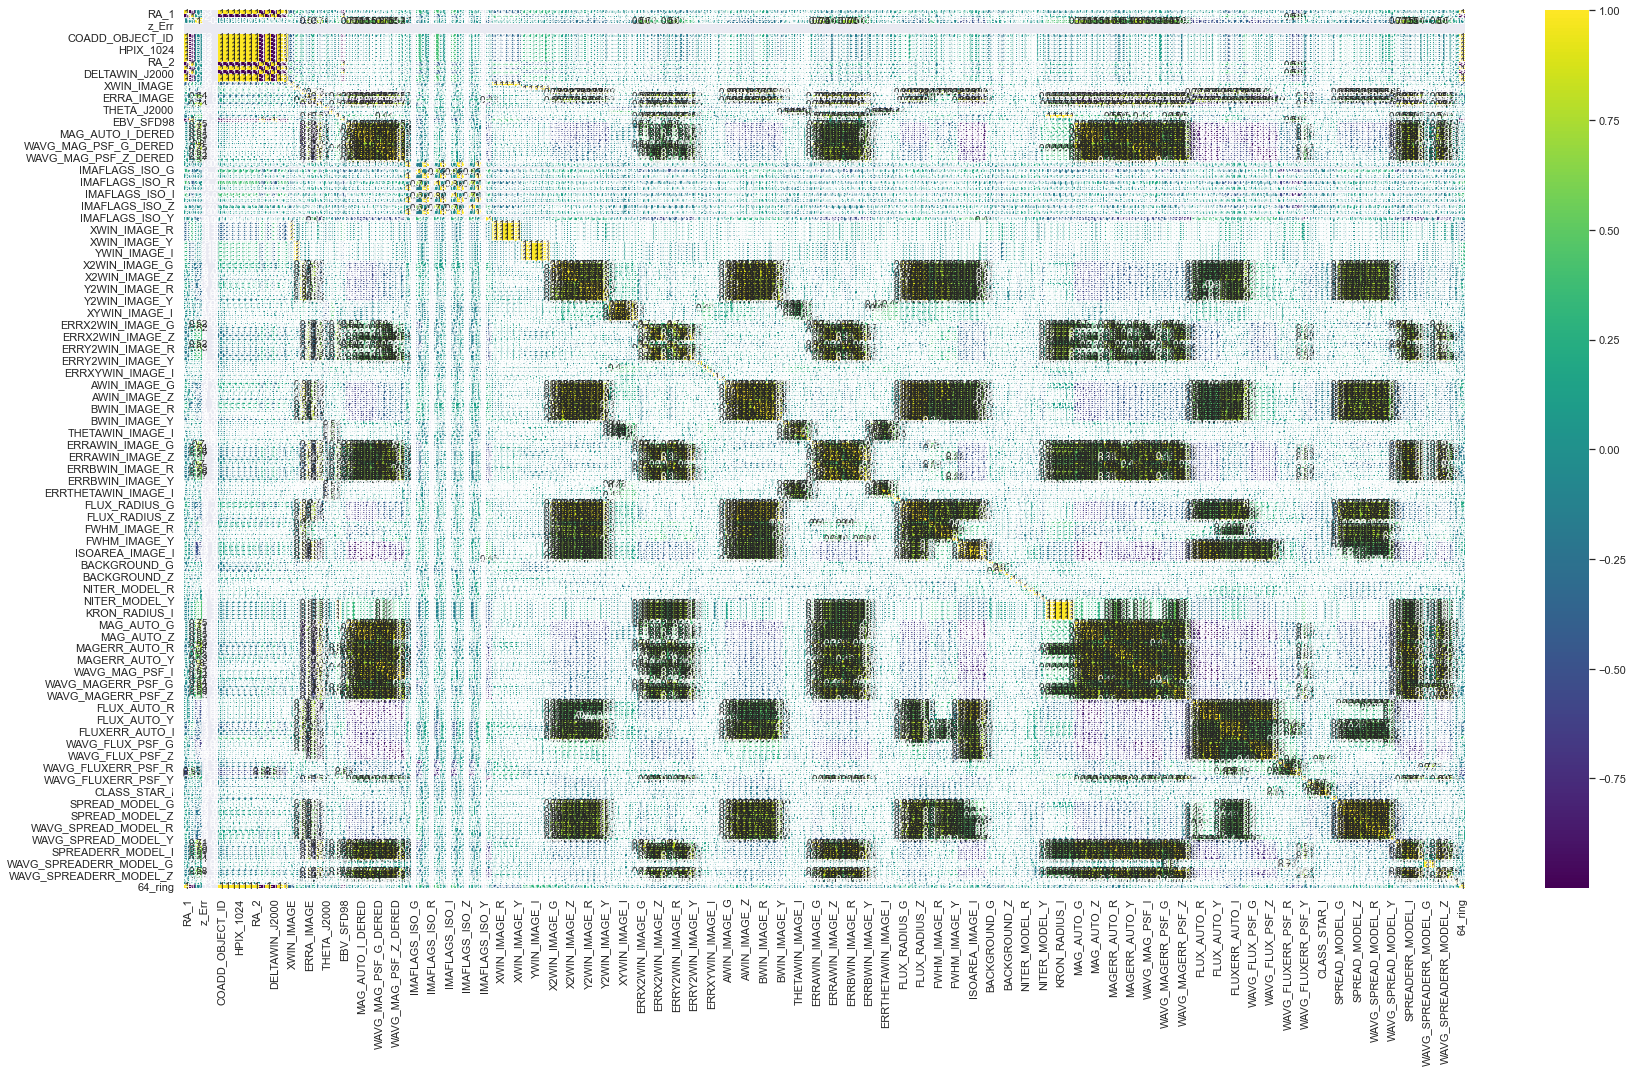

In [16]:
plt.figure(figsize=(32,18))
corrmat = vvds.corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat,annot=True,cmap="viridis")
plt.tight_layout()

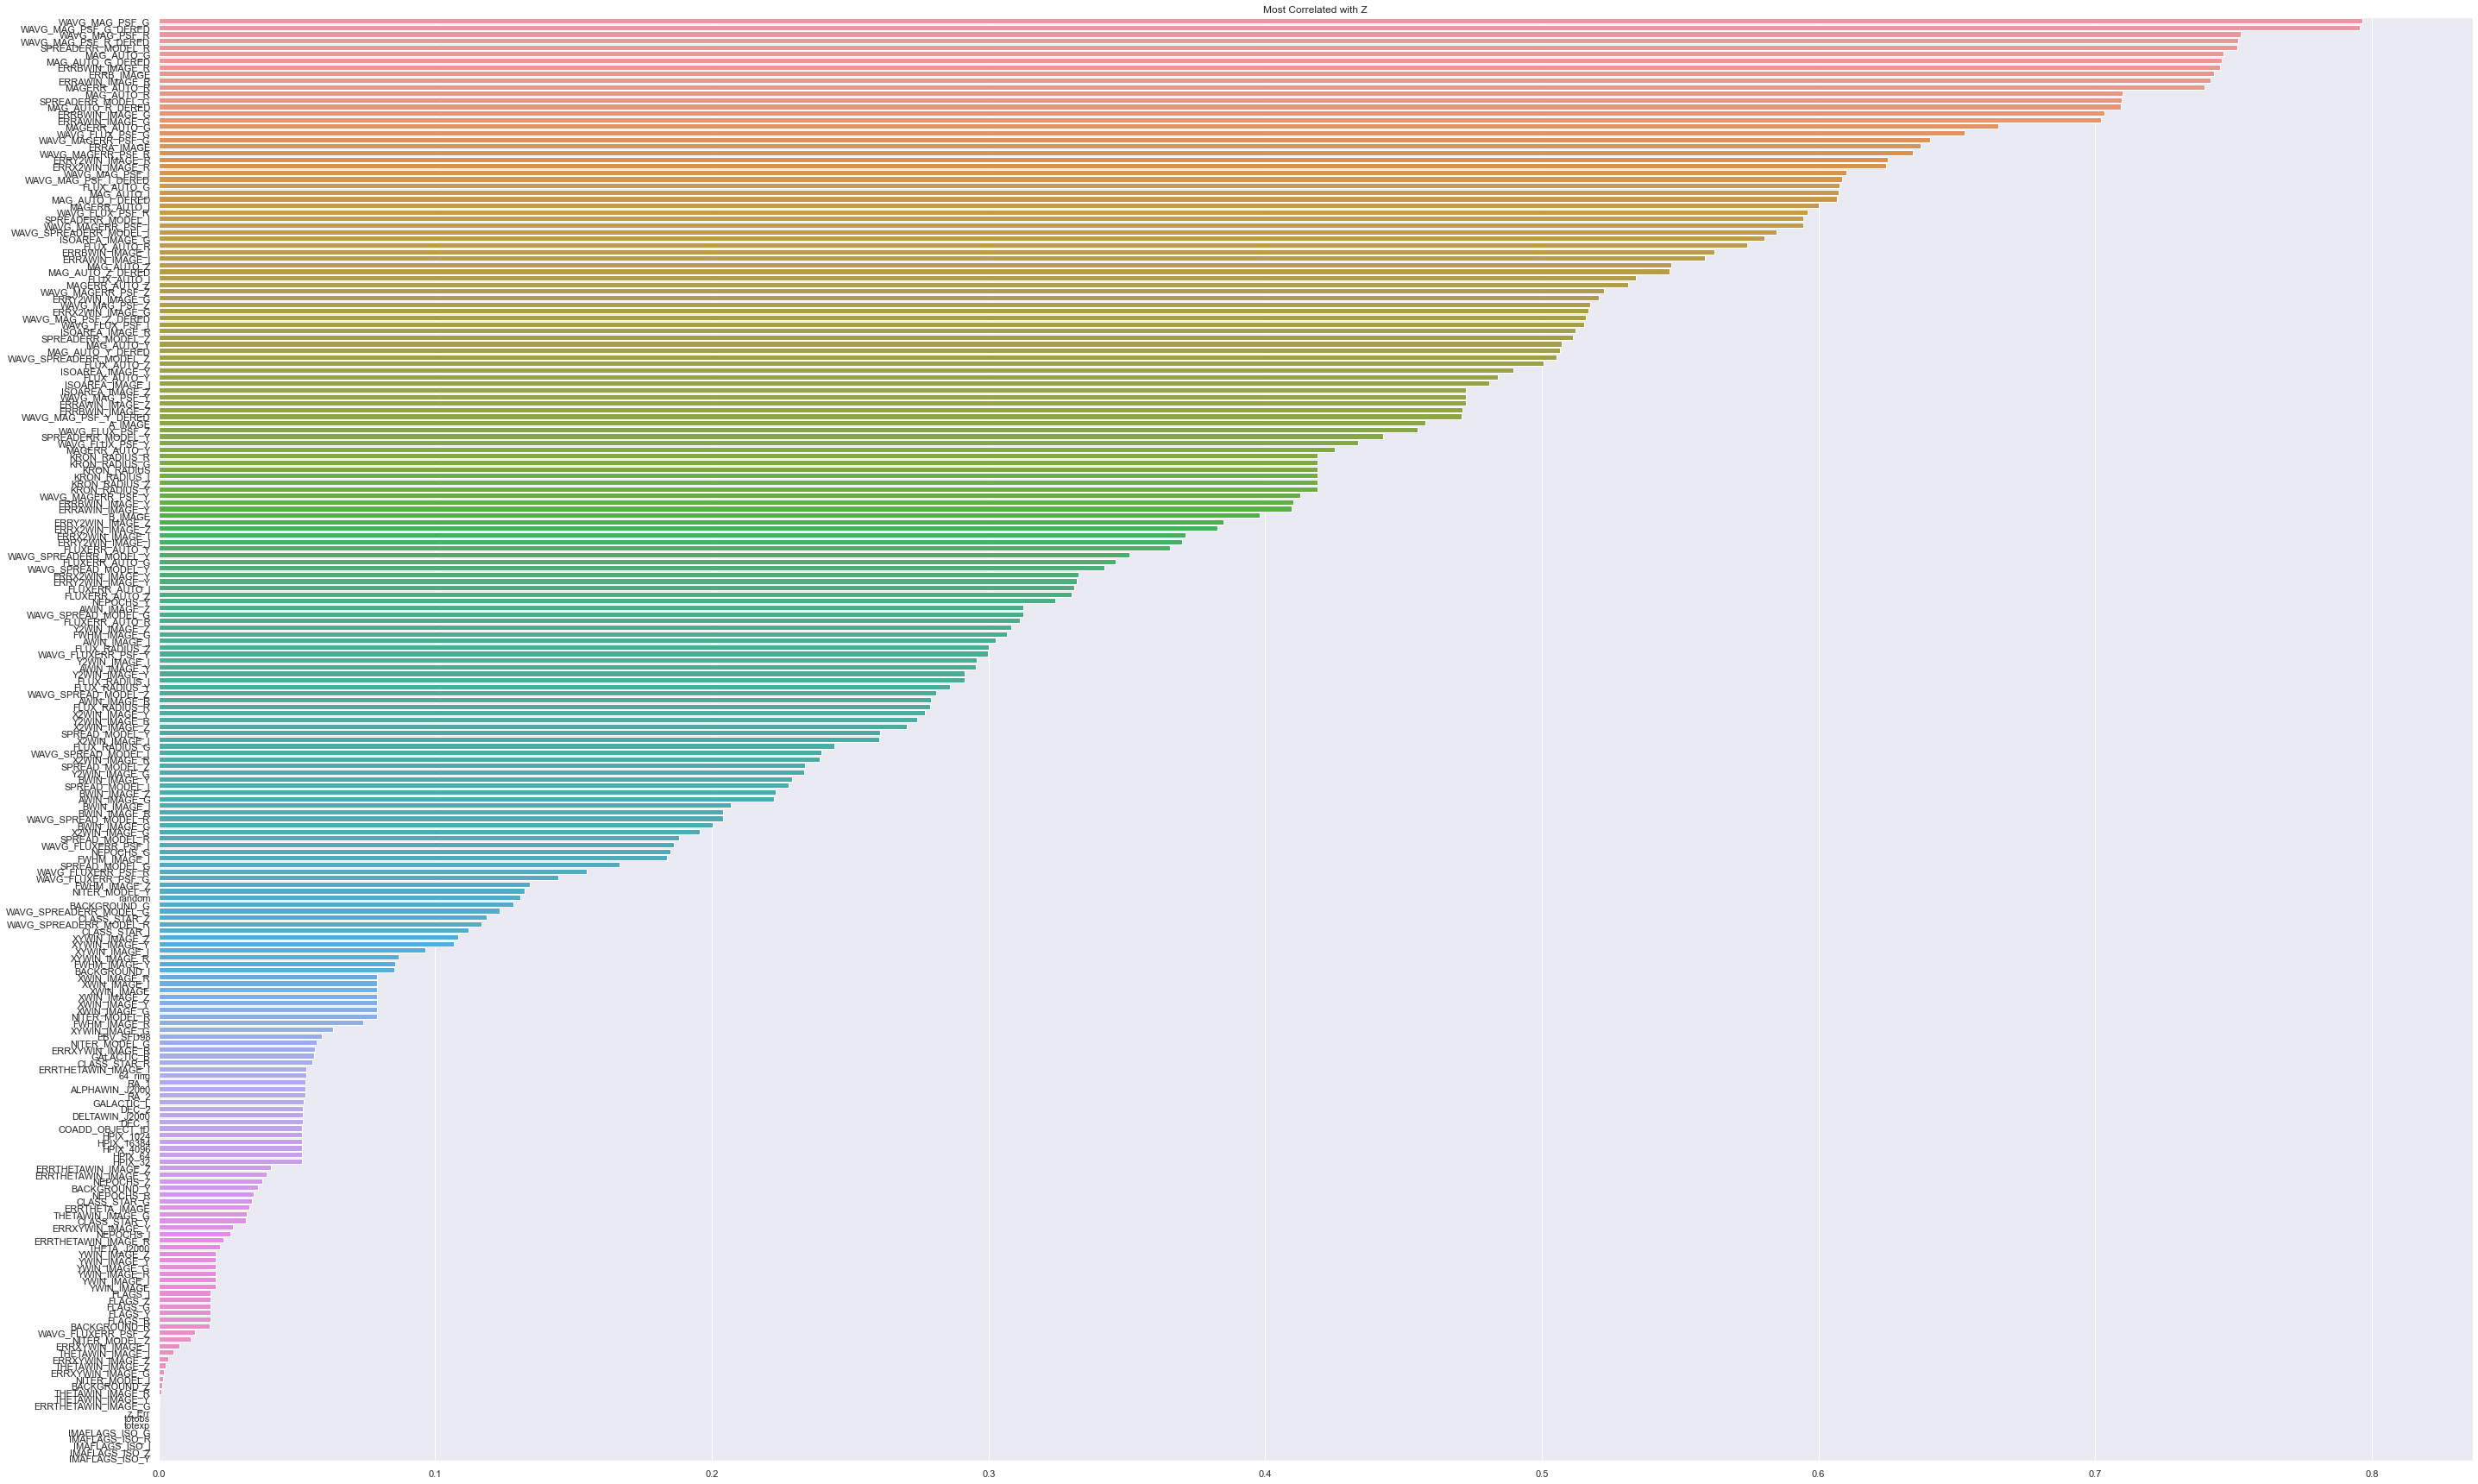

In [17]:
plt.figure(figsize=(40,24))
correlations =corrmat.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()
plt.savefig("correlations.png",dpi = 500,bbox_inches = "tight" )

In [18]:
mag_feat.append("z")

<Figure size 1152x576 with 0 Axes>

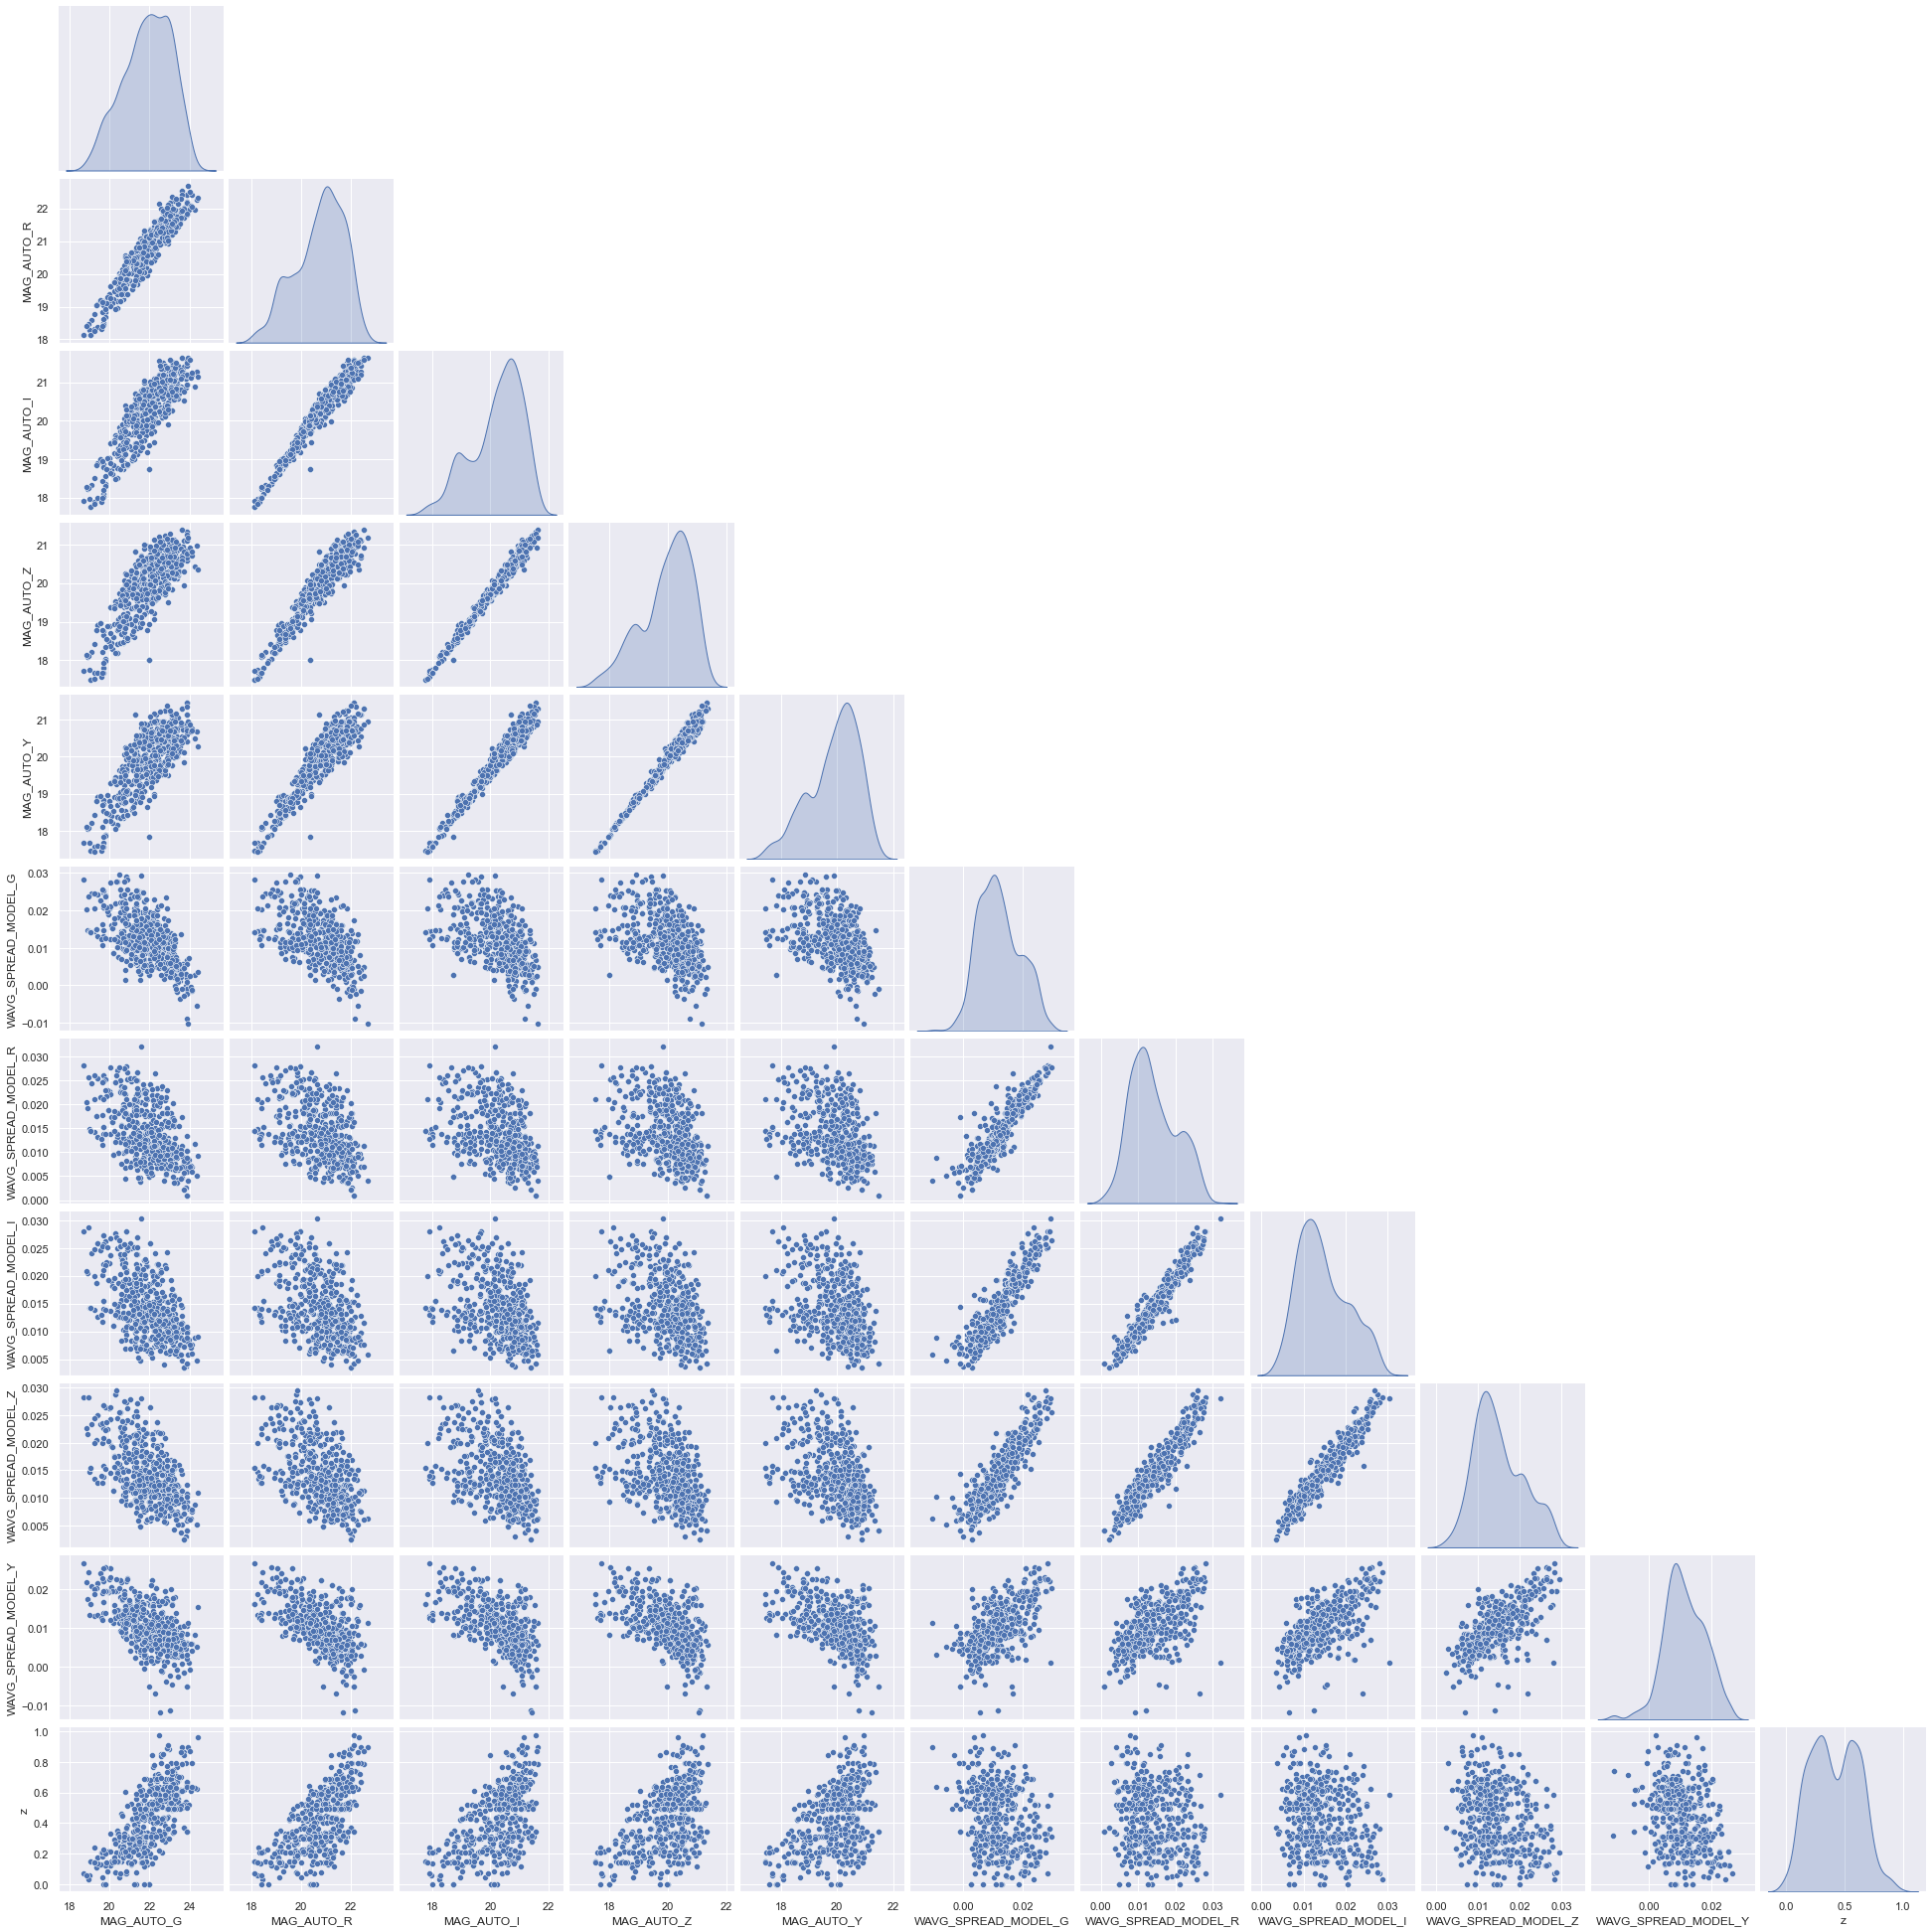

In [19]:
plt.figure(figsize=(16,8))
sns.pairplot(vvds[mag_feat],kind="scatter",diag_kind="kde",corner=True)

## Primeira implementação de ML

In [20]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()



In [21]:
X = vvds[mag_feat[0:10]].values
y = vvds["z"].values.reshape(-1,1)

X = rob_scaler.fit_transform(X)
y = rob_scaler.fit_transform(y)

In [22]:
def tts_split(X,y,size):
    rs = ShuffleSplit(n_splits=5, test_size=size, random_state=0)
    rs.get_n_splits(X)
    for train_index, test_index in rs.split(X, y): 
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test,y_train, y_test

In [23]:
X_train, X_test,y_train, y_test = tts_split(X,y,0.33333)

In [24]:
params_dict = {
            'KNeighborsRegressor': {'n_neighbors':list(range(3, 11))},
            'SVR' : {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.3]},
            'DecisionTreeRegressor' : {"min_samples_split": [10, 20], "max_depth": [2, 6]},
            'SGDRegressor': {'alpha': 10.0 ** -np.arange(1, 10), 'penalty': ['l2', 'l1', 'elasticnet'], 'learning_rate': ['constant', 'optimal', 'invscaling']},
            'RandomForestRegressor' : {"n_estimators": list(range(100,500,50)) ,"min_samples_split": [10, 20,30,40,50], "max_depth": [2, 6]},

}

In [25]:
KNNR = KNeighborsRegressor()
DTR = DecisionTreeRegressor()
SVR = SVR()
SGDR = SGDRegressor()
RFR = RandomForestRegressor()
algorithms = [KNNR, DTR, SVR,SGDR,RFR]


In [26]:
best_models = [] 
for algorithm in algorithms:
    clf = GridSearchCV(estimator=algorithm, param_grid=params_dict['{}'.format(algorithm.__class__.__name__)], cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train.ravel())
    best_models.append(clf.best_estimator_)
        

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.9s finished


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   49.1s finished


In [27]:
best_models

[KNeighborsRegressor(n_neighbors=3),
 DecisionTreeRegressor(max_depth=6, min_samples_split=10),
 SVR(C=10, epsilon=0.3, gamma=1e-07, kernel='linear'),
 SGDRegressor(learning_rate='constant'),
 RandomForestRegressor(max_depth=6, min_samples_split=10, n_estimators=200)]

In [28]:
evaluation = []
for model in best_models:
    predictions = model.predict(X_test)
    evaluation.append(mean_squared_error(y_test, predictions))

In [29]:
evaluation

[0.04887735,
 0.06741469983231972,
 0.09490280363576523,
 0.103604054601211,
 0.05078602550867638]

## Segunda implementação de ML


Modelos mais robustos para regresão

In [30]:
X = vvds[mag_feat[0:10]].values
y = vvds["z"].values.reshape(-1,1)

X_train, X_test,y_train, y_test = tts_split(X,y,0.33333)

In [31]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=None).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Base Models

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [32]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=None))

- **Elastic Net Regression** :

again made robust to outliers

In [33]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=None))

- **Kernel Ridge Regression** :

In [34]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [35]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =None)

- **XGBoost** :

In [36]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =None, nthread = -1)



- **LightGBM** :

In [37]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [38]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1256 (0.0134)



In [39]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1255 (0.0134)



In [40]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1186 (0.0121)



In [41]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.0832 (0.0045)



In [42]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[08:13:56] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:13:57] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:13:58] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:13:59] WARNING: ..

In [43]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

## Stacking Method

In [44]:
from ml_functions import StackingAveragedModels

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [45]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso,n_folds =5)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0811 (0.0053)


## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [46]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

**StackedRegressor:**

In [47]:
stacked_averaged_models.fit(X_train, y_train.ravel())
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test))
print(rmsle(y_train, stacked_train_pred))

0.040678069932405046


**XGBoost:**

In [48]:
model_xgb.fit(X_train, y_train.ravel())
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

[08:17:14] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.07365613


**LightGBM:**

In [49]:
model_lgb.fit(X_train, y_train.ravel())
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.05050104301354006


In [50]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.04515816157813977


**Ensemble prediction:**

In [52]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
ensemble

array([0.13963922, 0.75694783, 0.47195806, 0.14312075, 1.12706611,
       0.78958493, 0.48430188, 1.10762489, 0.55023993, 1.19917722,
       0.65366884, 0.11356265, 0.35652433, 0.45823439, 0.41542051,
       0.82615189, 0.94226788, 0.98166518, 0.23923452, 0.26771077,
       0.47195806, 0.70450282, 0.5153187 , 0.39777306, 0.72712606,
       0.28700434, 0.19364708, 0.53177123, 0.97892357, 0.37246086,
       0.80404883, 1.08298459, 0.14818716, 0.41601889, 0.40730575,
       0.65714799, 0.31983165, 0.35740527, 0.71021798, 0.7737279 ,
       1.16383235, 0.77067698, 0.90023551, 0.93576186, 0.20890616,
       0.64881439, 0.36374677, 0.17915598, 0.28661211, 0.74217992,
       1.09725375, 0.40692184, 0.39739488, 0.38872626, 0.70736614,
       0.36374677, 0.38797913, 0.22481933, 0.94226788, 0.97365872,
       0.45305984, 0.41410796, 1.08819944, 0.50629147, 0.27292772,
       0.50417862, 0.76575476, 1.10762489, 0.4224589 , 0.70918616,
       0.26111525, 1.25469123, 0.22481933, 0.75255999, 0.37246